In [35]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [3]:
# read dataset
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df = pd.read_csv(f).fillna(0)

# convert non-timeseries
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].astype(str)
df[['RegionID', 'RegionName', 'SizeRank']] = df[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower()
)

In [4]:
# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

In [5]:
# metro areas
hot_springs = df.loc[(df['Metro'] == 'hot springs') & (df['State'] == 'ar')]
little_rock = df.loc[(df['Metro'] == 'little rock') & (df['State'] == 'ar')]
fayetteville = df.loc[(df['Metro'] == 'fayetteville') & (df['State'] == 'ar')]
searcy = df.loc[(df['Metro'] == 'searcy') & (df['State'] == 'ar')]

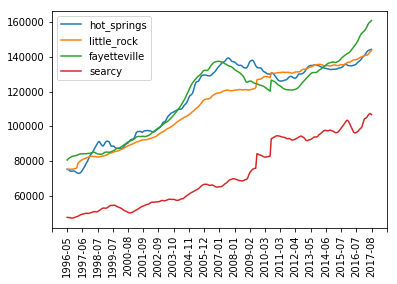

In [6]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [7]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [8]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [9]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [10]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1897.950
Method:                       css-mle   S.D. of innovations            677.352
Date:                Sat, 17 Nov 2018   AIC                           3809.901
Time:                        14:43:31   BIC                           3834.236
Sample:                    02-01-1997   HQIC                          3819.707
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        790.4705    688.262      1.149      0.252    -558.499    2139.440
ar.L1.D.y      0.3906      0.065      6.046      0.000       0.264       0.517
ar.L2.D.y      0.1321      0.068      1.943      0.0

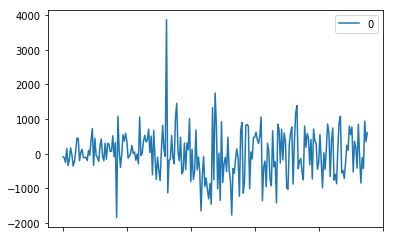

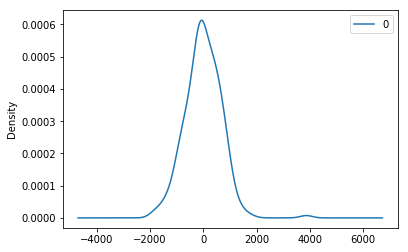

In [11]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [12]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean      2.044148
std     678.828434
min   -1839.800599
25%    -428.541806
50%     -20.754053
75%     440.493914
max    3867.851117


In [13]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=287857.603196, expected=287100.000000
prediction difference: 0.002639

predicted=287857.603196

date: 2017-3
-----------------------------------------------
predicted=289470.754665, expected=288000.000000
prediction difference: 0.005107

predicted=289470.754665

date: 2017-4
-----------------------------------------------
predicted=291093.245235, expected=288800.000000
prediction difference: 0.007941

predicted=291093.245235

date: 2017-5
-----------------------------------------------
predicted=292709.231553, expected=289500.000000
prediction difference: 0.011085

predicted=292709.231553

date: 2017-6
-----------------------------------------------
predicted=294276.612811, expected=291100.000000
prediction difference: 0.010912

predicted=294276.612811

date: 2017-7
-----------------------------------------------
predicted=295827.288992, expected=292000.000000
prediction difference: 0.013107

predicted=295827.28899

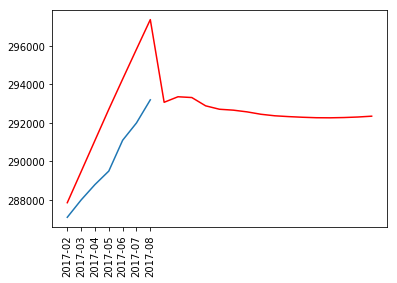

In [14]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [84]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        #
        # determine stationarity value: no need to difference more than
        #     half the lenght of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 2)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            autoreg = delta
            print('delta: {}, p: {}'.format(delta, result[1]))

            # dickey-fuller significant
            if (result[1] <= 0.05):
                # generate model
                try:
                    model = ARIMA(history, order=(autoreg, 2, 2))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('stationarity not adequate')
                    continue

        output = model_fit.forecast()
        yhat = output[0]

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [56]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

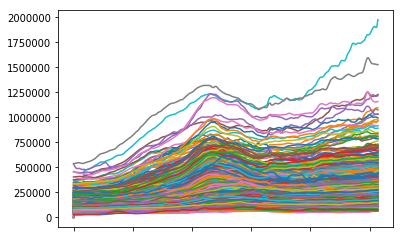

In [57]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [ ]:
## iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

# print first 10 prediction
#print(results[0:10])

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.3187671291031393
delta: 2, p: 0.03475181412401332
predictions: [array([225003.43430598])]
delta: 0, p: nan
delta: 1, p: 0.8726774466975695
delta: 2, p: 0.8482630143016459
delta: 3, p: 0.8666277195058221
delta: 4, p: 0.0
stationarity not adequate
delta: 5, p: 5.099275513103941e-12
stationarity not adequate
delta: 6, p: 2.277322663256925e-09
stationarity not adequate
delta: 7, p: 1.2566473486286529e-07
stationarity not adequate
delta: 8, p: 2.0824250101106382e-06
stationarity not adequate
delta: 9, p: 1.8046025333810255e-05
stationarity not adequate
delta: 10, p: 4.508178507277881e-05
stationarity not adequate
delta: 11, p: 0.0002094230192185614
stationarity not adequate
delta: 12, p: 0.00011687808927066568
stationarity not adequate
delta: 13, p: 0.0022274262662381216
stationarity not adequate
delta: 14, p: 0.004389279472040944
stationarity not adequate
delta: 15, p: 0.007252150409832875
stationarity not adequate
delta: 16, p: 0.013318003214428834
stationa

delta: 92, p: 0.5734510976354932
delta: 93, p: 0.56723190033733
delta: 94, p: 0.5651522633960683
delta: 95, p: 0.570381694102521
delta: 96, p: 0.5763732341100855
delta: 97, p: 0.5778658374006139
delta: 98, p: 0.5854492051108192
delta: 99, p: 0.5976232633839526
delta: 100, p: 0.6045165925514947
delta: 101, p: 0.6060719823176749
delta: 102, p: 0.6094064351679129
delta: 103, p: 0.6115984620601017
delta: 104, p: 0.6104663508542025
delta: 105, p: 0.6055525929926366
delta: 106, p: 0.5975698368359057
delta: 107, p: 0.5867121806495776
delta: 108, p: 0.5728344108291334
delta: 109, p: 0.5569252049761192
delta: 110, p: 0.5410936505463345
delta: 111, p: 0.5279803528795133
delta: 112, p: 0.5184347365487632
delta: 113, p: 0.5110806555787686
delta: 114, p: 0.5072059866939677
delta: 115, p: 0.5041039504871552
delta: 116, p: 0.4978951105705269
delta: 117, p: 0.4892355929074735
delta: 118, p: 0.47875774571397217
delta: 119, p: 0.46466785755469875
delta: 120, p: 0.45501285671202074
delta: 121, p: 0.44951

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less_equal


delta: 0, p: [nan]
delta: 1, p: [9.77173087e-28]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157])]
delta: 0, p: [nan]
delta: 1, p: [1.02332308e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473])]
delta: 0, p: [nan]
delta: 1, p: [1.08190105e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923])]
delta: 0, p: [nan]
delta: 1, p: 

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114])]
delta: 0, p: [nan]
delta: 1, p: [1.75347078e-27]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114]), array([339930.62082807])]
delta: 0, p: [nan]
delta: 1, p: [1.93503478e-27]
predictions: [arra

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27890654]), array([329826.26040603]), array([334843.68227114]), array([339930.62082807]), array([345081.39445411]), array([350290.7456342]), array([355553.96169372]), array([360867.15605772]), array([366226.47841691])]
delta: 0, p: [nan]
delta: 1, p: [2.45079158e-17]
predictions: [array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([225003.43430598]), array([293961.37264435]), array([295501.93930531]), array([296258.79738763]), array([297331.58089802]), array([301617.76271157]), array([306044.54339473]), array([310594.7275923]), array([315257.50515749]), array([320027.99749746]), array([324885.27